In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import sctop as top

In [2]:
# Change seaborn settings to make our plots prettier
# Feel free to edit as desired, or remove entirely
sns.set(context='talk', color_codes=True, palette='deep', style='whitegrid',
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':400, 'text.usetex':False}) #font_scale=0.3,

In [3]:
basis_MCKO, tags_MCKO = top.load_basis('MC-KO', 0)
basis_LD, tags_LD = top.load_basis('LD', 0)

basis_MCKO_cutoff, tags_MCKO_cutoff = top.load_basis('MC-KO', 100)
basis_LD_cutoff, tags_LD_cutoff = top.load_basis('LD', 100)

In [4]:
# Add lung early epithelium to basis
epithelium_profile = basis_LD_cutoff.loc[:,'Lung Early Epithelium Cell E12 LD21']
basis_genes = np.intersect1d(basis_MCKO_cutoff.index, basis_LD_cutoff.index)
new_basis = pd.concat([basis_MCKO_cutoff.loc[basis_genes],
                      epithelium_profile.loc[basis_genes]],
                      axis=1
                     )

# Plot trajectory of ALD AT1 and AT2 in new basis
alveolar_types = [alveolar for alveolar in tags_LD.index if 
                  ('AT' in alveolar)
                  and ('Mk' not in alveolar)
                  and not ((' P' in alveolar) and (' P0' not in alveolar))
                 ]
alveolar_data = basis_LD.loc[:, alveolar_types]
alveolar_projections = top.score(new_basis, alveolar_data)

In [5]:
from matplotlib.cm import ScalarMappable

def create_colorbar(data, label, colormap='rocket_r', **kwargs):
#     ax = ax or plt.gca()
    
    cmap = plt.get_cmap(colormap)
    scalarmap = ScalarMappable(norm=plt.Normalize(min(data), max(data)),
                               cmap=cmap)
    scalarmap.set_array([])
    plt.colorbar(scalarmap, label=label, **kwargs)
    
    return cmap

["The genomic, epigenomic and biophysical cues controlling the emergence of the gas exchange niche in the lung"](https://www-ncbi-nlm-nih-gov.ezproxy.bu.edu/geo/query/acc.cgi?acc=GSE149563)

In [6]:
from scanpy import read_h5ad
import h5py

metadata_file = '/projectnb/biophys/mariay/mouse/samples/GSE149563 (lung emergence)/local.h5ad'
lungMAP_metadata = read_h5ad(metadata_file)

lungMAP_files = {'E12.5': 'GSM4504959_E12.5', 
                 'E15.5': 'GSM4504960_E15.5', 
                 'E17.5': 'GSM4504961_E17.5', 
                 'P3': 'GSM4504962_P3', 
                 'P7': 'GSM4504963_P7', 
                 'P15': 'GSM4504964_P15', 
                 'P42': 'GSM4504965_P42'
                }

lungMAP_data = dict()

for day, substring in tqdm(lungMAP_files.items()):
#     Only run the commented-out part when reading in for the first time
#     file_string = '/projectnb/biophys/mariay/mouse/samples/GSE149563 (lung emergence)/{}_filtered_gene_bc_matrices.h5'.format(lungMAP_files[day])
#     lungMAP_files[day] = h5py.File(file_string, 'r')
    current_dataframe = pd.read_csv("./manuscript data/lungMAP_{}.csv".format(day))
    current_dataframe = current_dataframe.set_index('Unnamed: 0')
    common_genes = np.intersect1d(lungMAP_metadata.var.index, current_dataframe.index)
    current_dataframe = current_dataframe.loc[common_genes]
    current_dataframe.index = lungMAP_metadata.var.feature_name.loc[common_genes].values
    lungMAP_data[day] = current_dataframe

100%|██████████| 7/7 [06:21<00:00, 54.52s/it]


In [7]:
# This cell converts the lungMAP h5 files to csv. It takes about 2 hours, so only run once!

lungMAP_data = dict()

for day, file in tqdm(lungMAP_files.items()):
    current_df_list = []
    genes = np.array([gene.decode("utf-8") for gene in file['mm10']['genes']])
#     unique_genes, gene_counts = np.unique(genes, return_counts=True)
#     duplicated_gene_names = [gene for gene, count in zip(unique_genes, gene_counts) if count > 1]
    
#     gene_indices_to_drop = np.array([]) # indices of duplicated genes, after the first one
#     for gene in duplicated_gene_names:
#         gene_indices_to_drop = np.append(gene_indices_to_drop, np.where(genes == gene)[0][1:])
    
    unique_genes = genes
    zero_counts = np.full_like(unique_genes, 0)
    
    for index, barcode in enumerate(file['mm10']['barcodes']):
        day_label = day.replace('P42', 'Adult')
        barcode_label = barcode.decode('utf-8')[:-1] + day_label
        current_df = pd.DataFrame(zero_counts, index = unique_genes, columns = [barcode_label])
        
        start_ptr, end_ptr = (file['mm10']['indptr'][index], file['mm10']['indptr'][index+1])
#         for pointer in range(start_ptr, end_ptr):
#             current_df.loc[genes[file['mm10']['indices'][pointer]]] = file['mm10']['data'][pointer]
        pointers = np.arange(int(start_ptr), int(end_ptr))
    
#         gene_indices_to_keep = np.setdiff1d(file['mm10']['indices'][pointers], gene_indices_to_drop)
#         duplicated_indices = np.intersect1d(file['mm10']['indices'][pointers], gene_indices_to_drop)
#         data_indices_to_drop = np.array([])
#         for gene_index in duplicated_indices:
#             data_indices_to_drop = np.append(data_indices_to_drop, np.where(file['mm10']['indices'] == gene_index)[0])
        
#         data_indices_to_drop = np.where(file['mm10']['indices'] == duplicated_indices[0])[0]
#         pointers = np.setdiff1d(pointers, data_indices_to_drop)
        current_df.loc[genes[file['mm10']['indices'][pointers]], barcode_label] = file['mm10']['data'][pointers]
            
        current_df_list += [current_df]
    
    lungMAP_data[day] = pd.concat(current_df_list, axis=1)
    lungMAP_data[day].to_csv('./manuscript data/lungMAP_{}.csv'.format(day))

100%|██████████| 7/7 [1:50:30<00:00, 947.17s/it] 


In [7]:
# look at type I & II pneumocytes as well as progenitor cell
types = ['type I pneumocyte', 'type II pneumocyte', 'progenitor cell', 'club cell']
lungMAP_processed = dict()
lungMAP_scores = dict()

for current_type in tqdm(types):
    barcodes = lungMAP_metadata.obs.index[lungMAP_metadata.obs['cell_type'] == current_type]
    current_raw_list = []
    current_timepoints = np.array([])
    
    for day, dataframe in lungMAP_data.items():
        relevant_barcodes = np.intersect1d(barcodes, dataframe.columns)
        current_raw_list += [dataframe.loc[:, relevant_barcodes]]
        timepoints = np.full(len(relevant_barcodes), day)
        current_timepoints = np.append(current_timepoints, timepoints)
        
    current_raw = pd.concat(current_raw_list, axis=1)
    current_processed = top.process(current_raw)
    lungMAP_processed[current_type] = current_processed
    
    current_scores = top.score(new_basis, current_processed)
    lungMAP_scores[current_type] = current_scores
    lungMAP_scores[current_type].loc['day'] = current_timepoints
    lungMAP_scores[current_type].loc['annotation'] = np.full(len(current_timepoints), current_type)

100%|██████████| 4/4 [00:51<00:00, 12.88s/it]


In [8]:
type_signatures = pd.read_csv('./manuscript data/herriges_cell_type_signatures.csv')
type_signatures = type_signatures.dropna(how='all')

pneumocytes = pd.concat([lungMAP_processed['type I pneumocyte'], lungMAP_processed['type II pneumocyte'], lungMAP_processed['progenitor cell']], axis=1)
AT1_signature = type_signatures.loc[:, 'Mouse_AT1'].dropna()
AT2_signature = type_signatures.loc[:, 'Mouse_AT2'].dropna()

pneumocytes_AT1 = pneumocytes.loc[AT1_signature].mean(axis=0)
pneumocytes_AT2 = pneumocytes.loc[AT2_signature].mean(axis=0)

In [16]:
coexpressing = pneumocytes.loc[:, np.logical_and(current_data.loc[typeX] > 0.1, current_data.loc[typeY] > 0.1)]
everything_else = pneumocytes.loc[:, np.logical_not(np.logical_and(current_data.loc[typeX] > 0.1, current_data.loc[typeY] > 0.1))]
difference = coexpressing.mean(axis=1) - everything_else.mean(axis=1)

difference.sort_values(ascending=False)[:50]

Slc34a2          1.398461
Sftpb            1.316173
Hopx             1.310609
Sftpa1           1.305830
Retnla           1.286594
Cxcl15           1.272591
Napsa            1.223684
Msln             1.183366
Cryab            1.159978
Akap5            1.136144
Lamp3            1.127271
S100a6           1.085272
Aqp5             1.081276
Clic5            1.075420
2200002D01Rik    1.066641
Lmo7             1.066167
Clic3            1.011580
Cbr2             1.004693
Ahnak            0.977970
Dram1            0.976850
S100g            0.974944
Lyz1             0.965712
Fbln5            0.959921
Vegfa            0.951935
Abca3            0.950595
Col4a4           0.939918
AU021092         0.934307
Tinagl1          0.917227
Pi4k2b           0.915468
Tmem213          0.895391
Pla2g1b          0.894233
Anxa3            0.884141
Emp2             0.876966
Gprc5a           0.875531
Neat1            0.872930
Sftpd            0.865095
Dcxr             0.860149
S100a14          0.857178
Npnt        

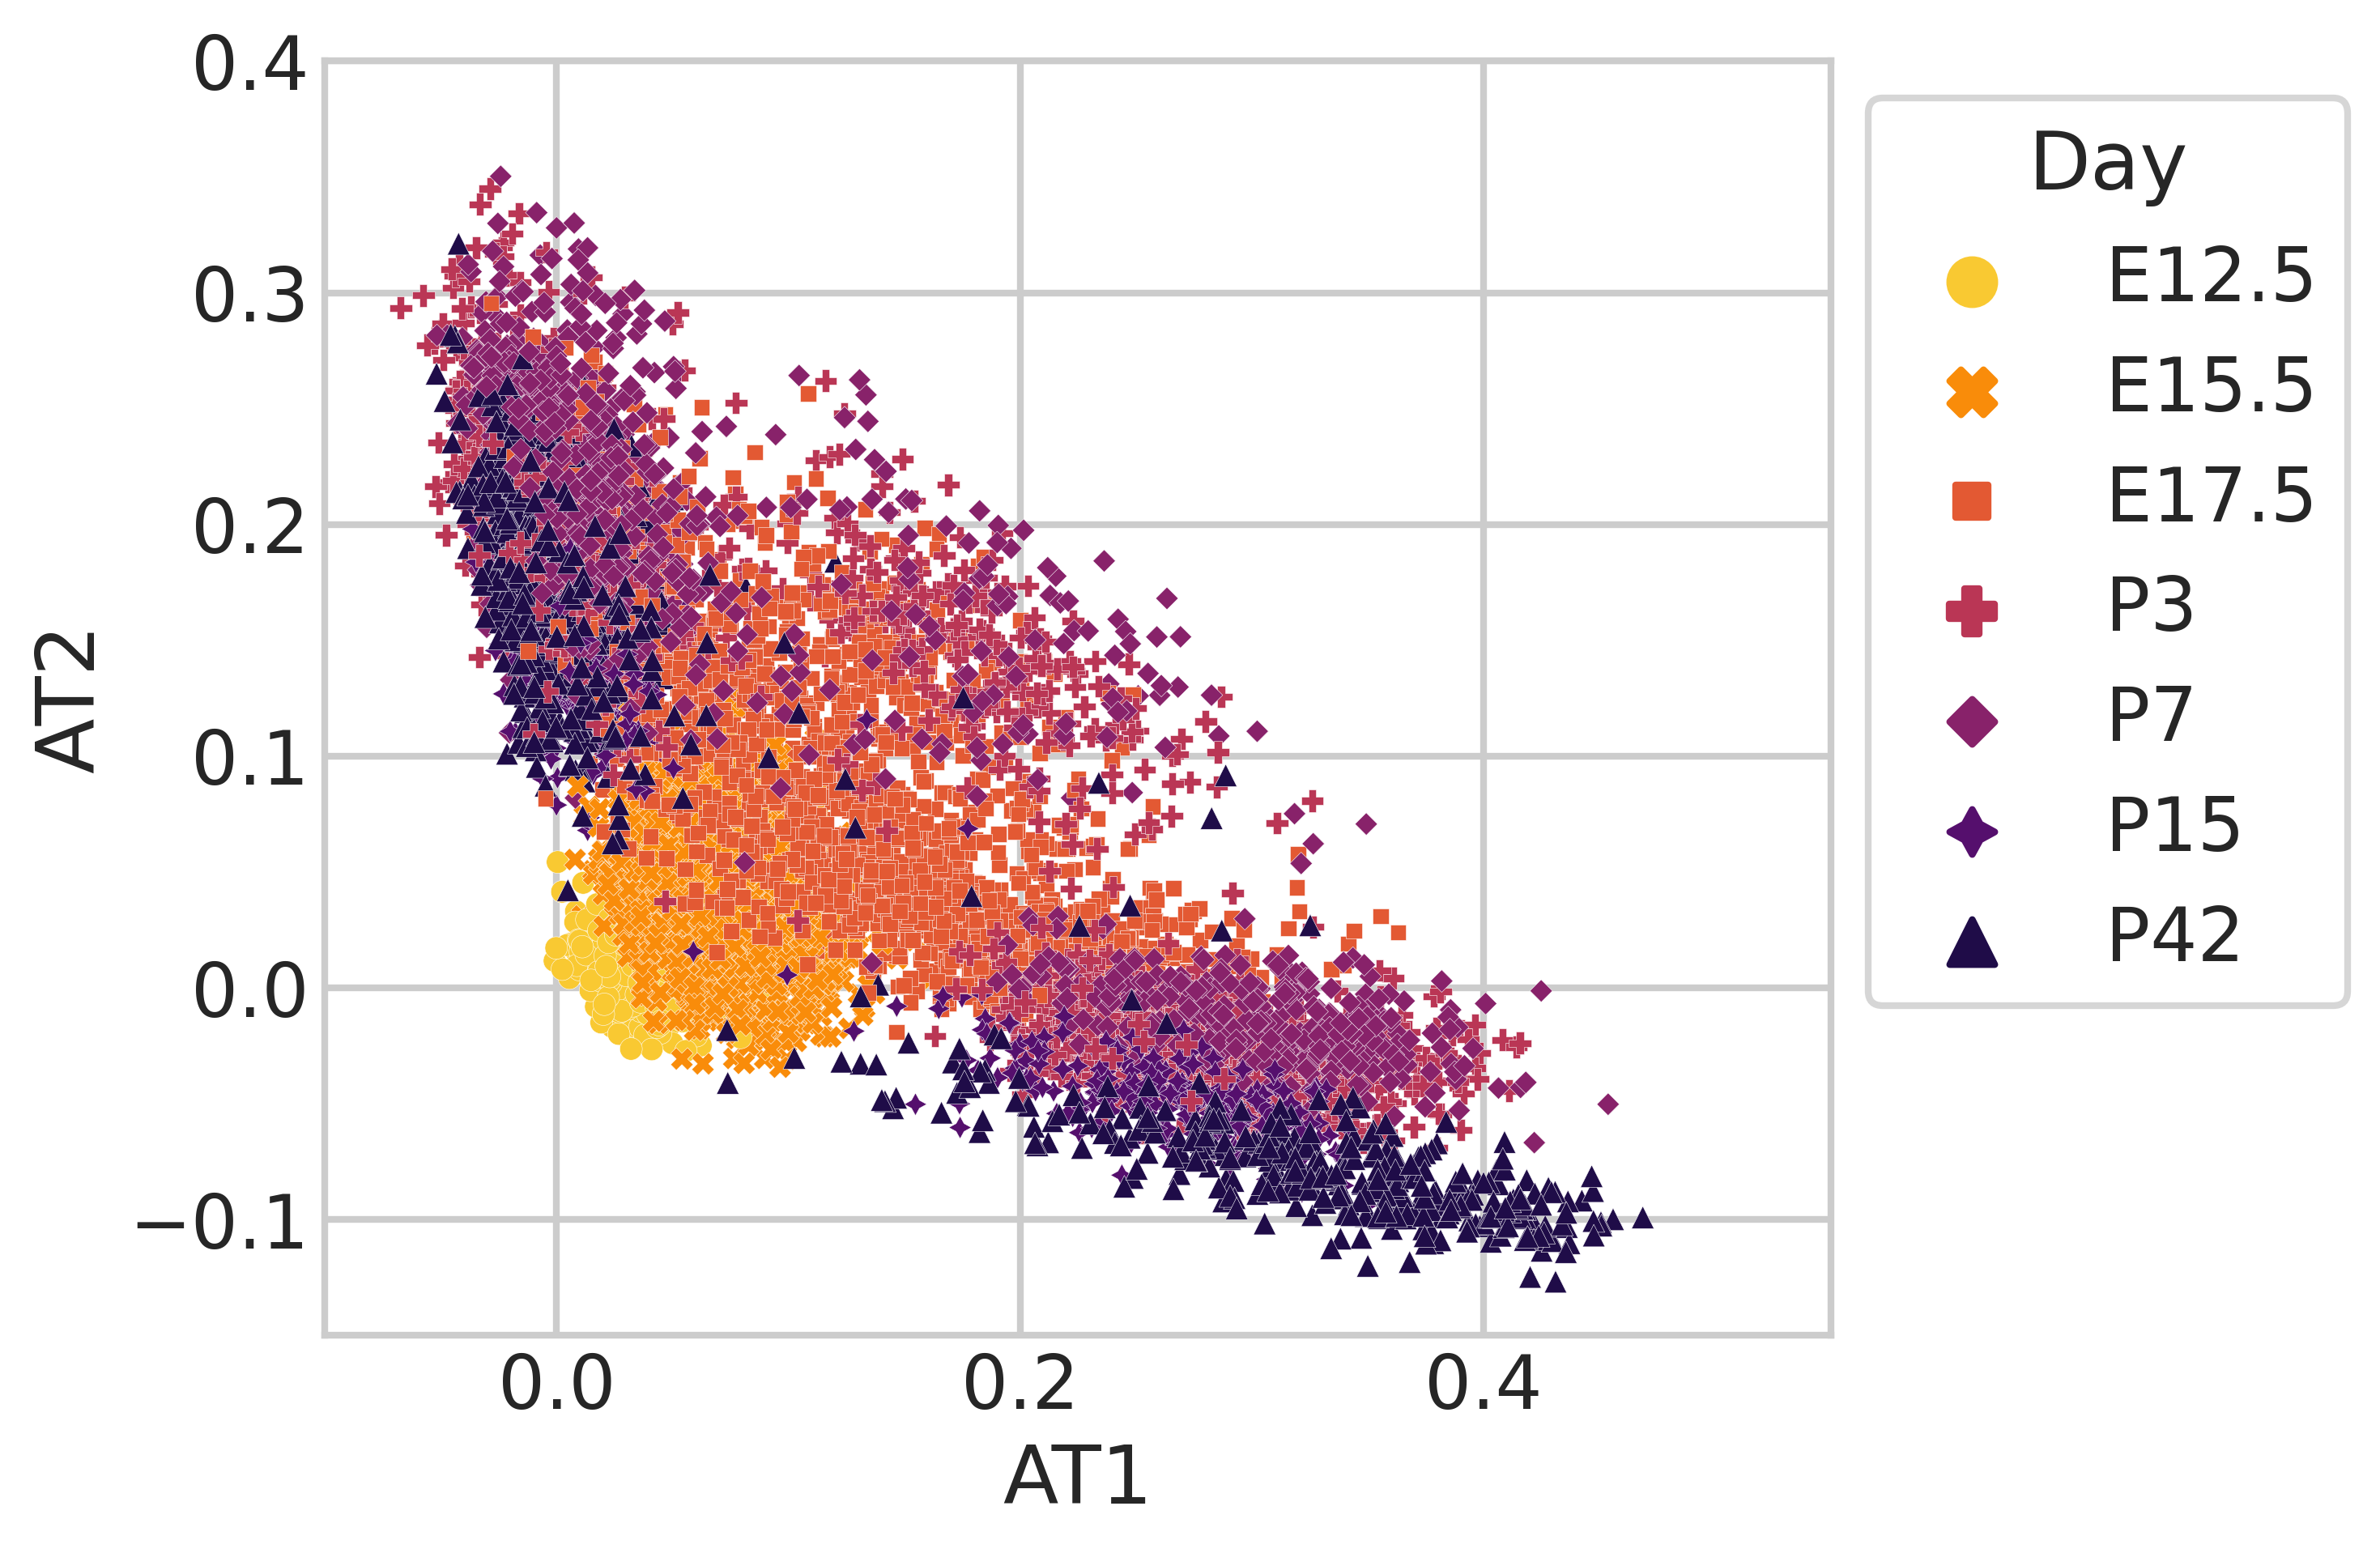

In [46]:
plt.figure(figsize=(6,6))

current_data = pd.concat([lungMAP_scores['type I pneumocyte'], lungMAP_scores['type II pneumocyte'], lungMAP_scores['progenitor cell']], axis=1)
typeX = 'Lung AT1 Cell WK6 KO22' # type to plot on x-axis
typeY = 'Lung AT2 Cell WK6 KO22' # type to plot on y-axis

# current_data = current_data.loc[:,current_data.loc['day'] == 'P42']
# type_hue = 'Lung Early Epithelium Cell E12 LD21'
type_hue = 'day'

# markers = []
# for cell_type in alveolar_projections.columns:
#     if 'AT1' in cell_type:
#         marker = '1'
#     if 'AT2' in cell_type:
#         marker = '2'
#     markers += [marker]
    
# cmap = create_colorbar(current_data.loc[type_hue], type_hue,
#                        colormap='RdBu', ax = plt.gca()) #sns.cubehelix_palette(as_cmap=True, reverse=True)
    
sns.scatterplot(x=current_data.loc[typeX],
                y=current_data.loc[typeY],
                hue=current_data.loc[type_hue],
#                 s=0.5*(len(annotation)**3),
#                 alpha=0.8,
#                 marker='${}$'.format(annotation),
                style = current_data.loc[type_hue],
#                 legend=False,
                palette='inferno_r',
                linewidth=0.1,
                s = 25,
                ax=plt.gca()
               )

plt.xlabel('AT1')
plt.ylabel('AT2')
plt.gca().set_aspect('equal')
plt.xlim([-0.1, 0.55])
plt.ylim([-0.15, 0.4])
lgnd = plt.legend(bbox_to_anchor=(1,1), loc="upper left", title='Day', scatterpoints=1)
for legend_entry in lgnd.legendHandles:
    legend_entry._sizes = [100]
plt.savefig("./manuscript figures/fig4_lungMAP_scatter_day.png", bbox_inches = "tight")
plt.show()

/scratch/146686.1.ood/ipykernel_17549/1878469578.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmap, label=label, **kwargs)
/scratch/146686.1.ood/ipykernel_17549/1878469578.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmap, label=label, **kwargs)


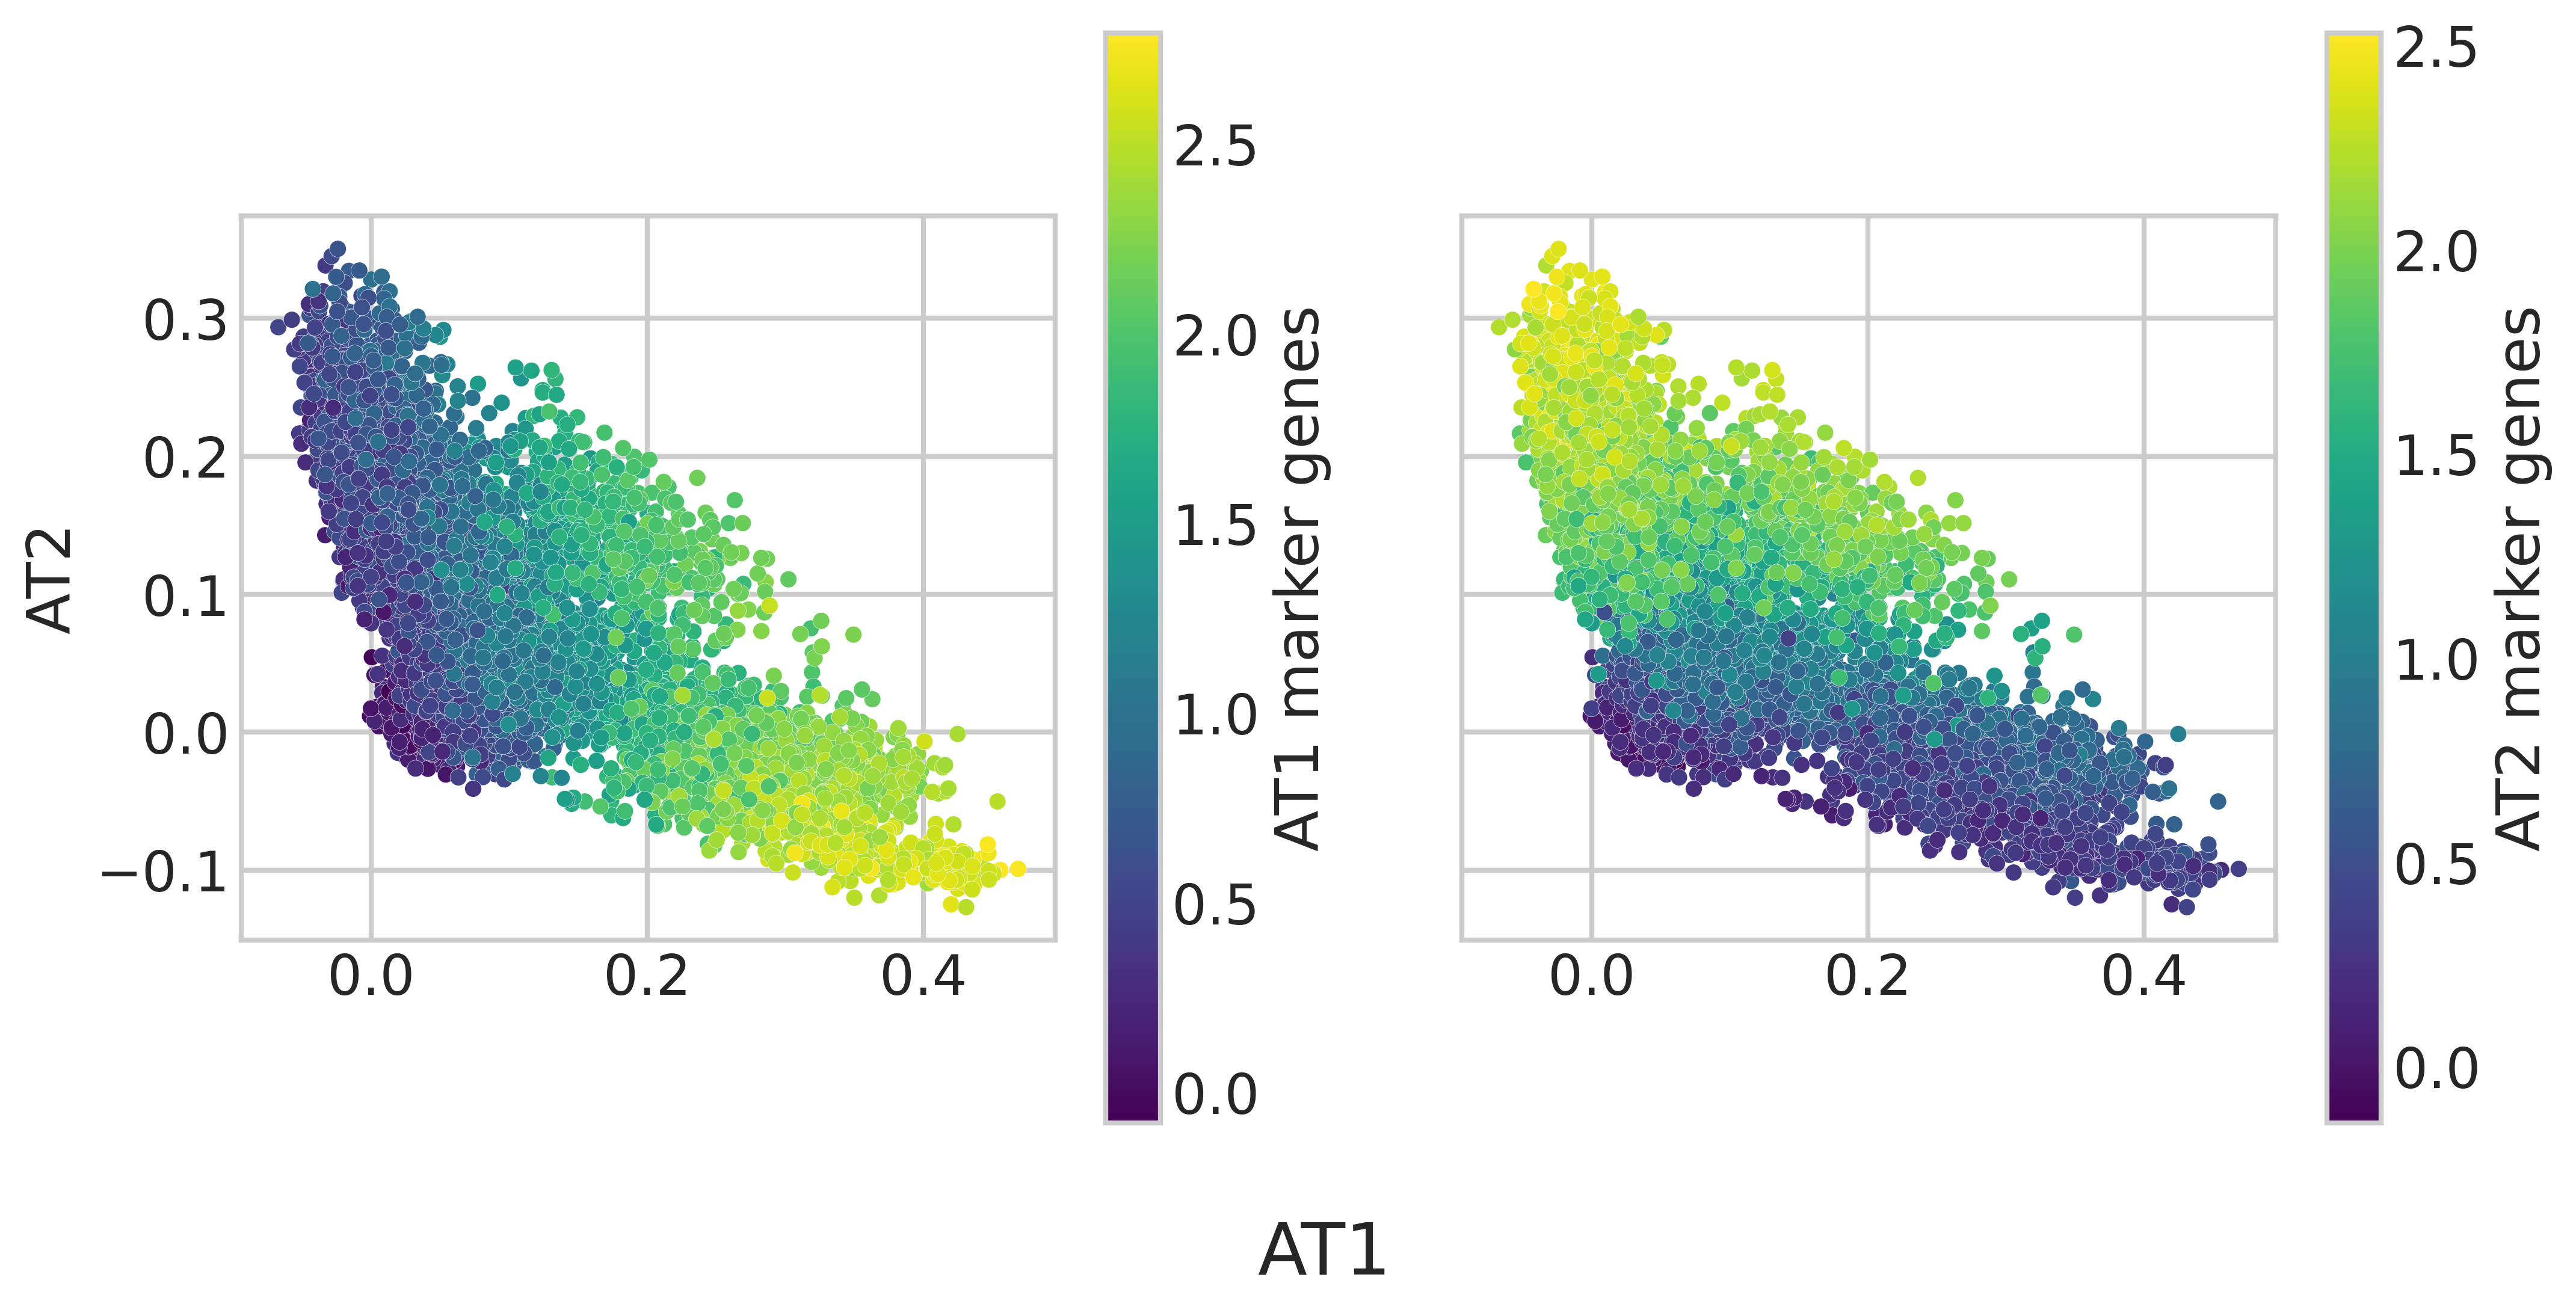

In [42]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6))
axes_list = axes.flatten()

current_data = pd.concat([lungMAP_scores['type I pneumocyte'], lungMAP_scores['type II pneumocyte'], lungMAP_scores['progenitor cell']], axis=1)
typeX = 'Lung AT1 Cell WK6 KO22' # type to plot on x-axis
typeY = 'Lung AT2 Cell WK6 KO22' # type to plot on y-axis
    
cmap = create_colorbar(pneumocytes_AT1, 'AT1 marker genes',
                       colormap='viridis', ax = axes_list[0])
    
sns.scatterplot(x=current_data.loc[typeX],
                y=current_data.loc[typeY],
                hue=pneumocytes_AT1,
                legend=False,
                palette='viridis',
                linewidth=0.1,
                s = 25,
                ax=axes_list[0]
               )

cmap = create_colorbar(pneumocytes_AT2, 'AT2 marker genes',
                       colormap='viridis', ax = axes_list[1])

sns.scatterplot(x=current_data.loc[typeX],
                y=current_data.loc[typeY],
                hue=pneumocytes_AT2,
                legend=False,
                palette='viridis',
                linewidth=0.1,
                s = 25,
                ax=axes_list[1]
               )

for ax in axes_list:
    ax.set_xlabel('')
    ax.set_ylabel('AT2')
    ax.set_aspect('equal')

fig.supxlabel('AT1')
# lgnd = plt.legend(bbox_to_anchor=(1,1), loc="upper left", title='Day', scatterpoints=1)
# for legend_entry in lgnd.legendHandles:
#     legend_entry._sizes = [100]
plt.savefig("./manuscript figures/fig4_lungMAP_scatter_markergenes.png", bbox_inches = "tight")
plt.show()

/scratch/144369.1.ood/ipykernel_27922/1188245503.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmap, label=label, ax = ax, fraction=0.03, pad=0.1)


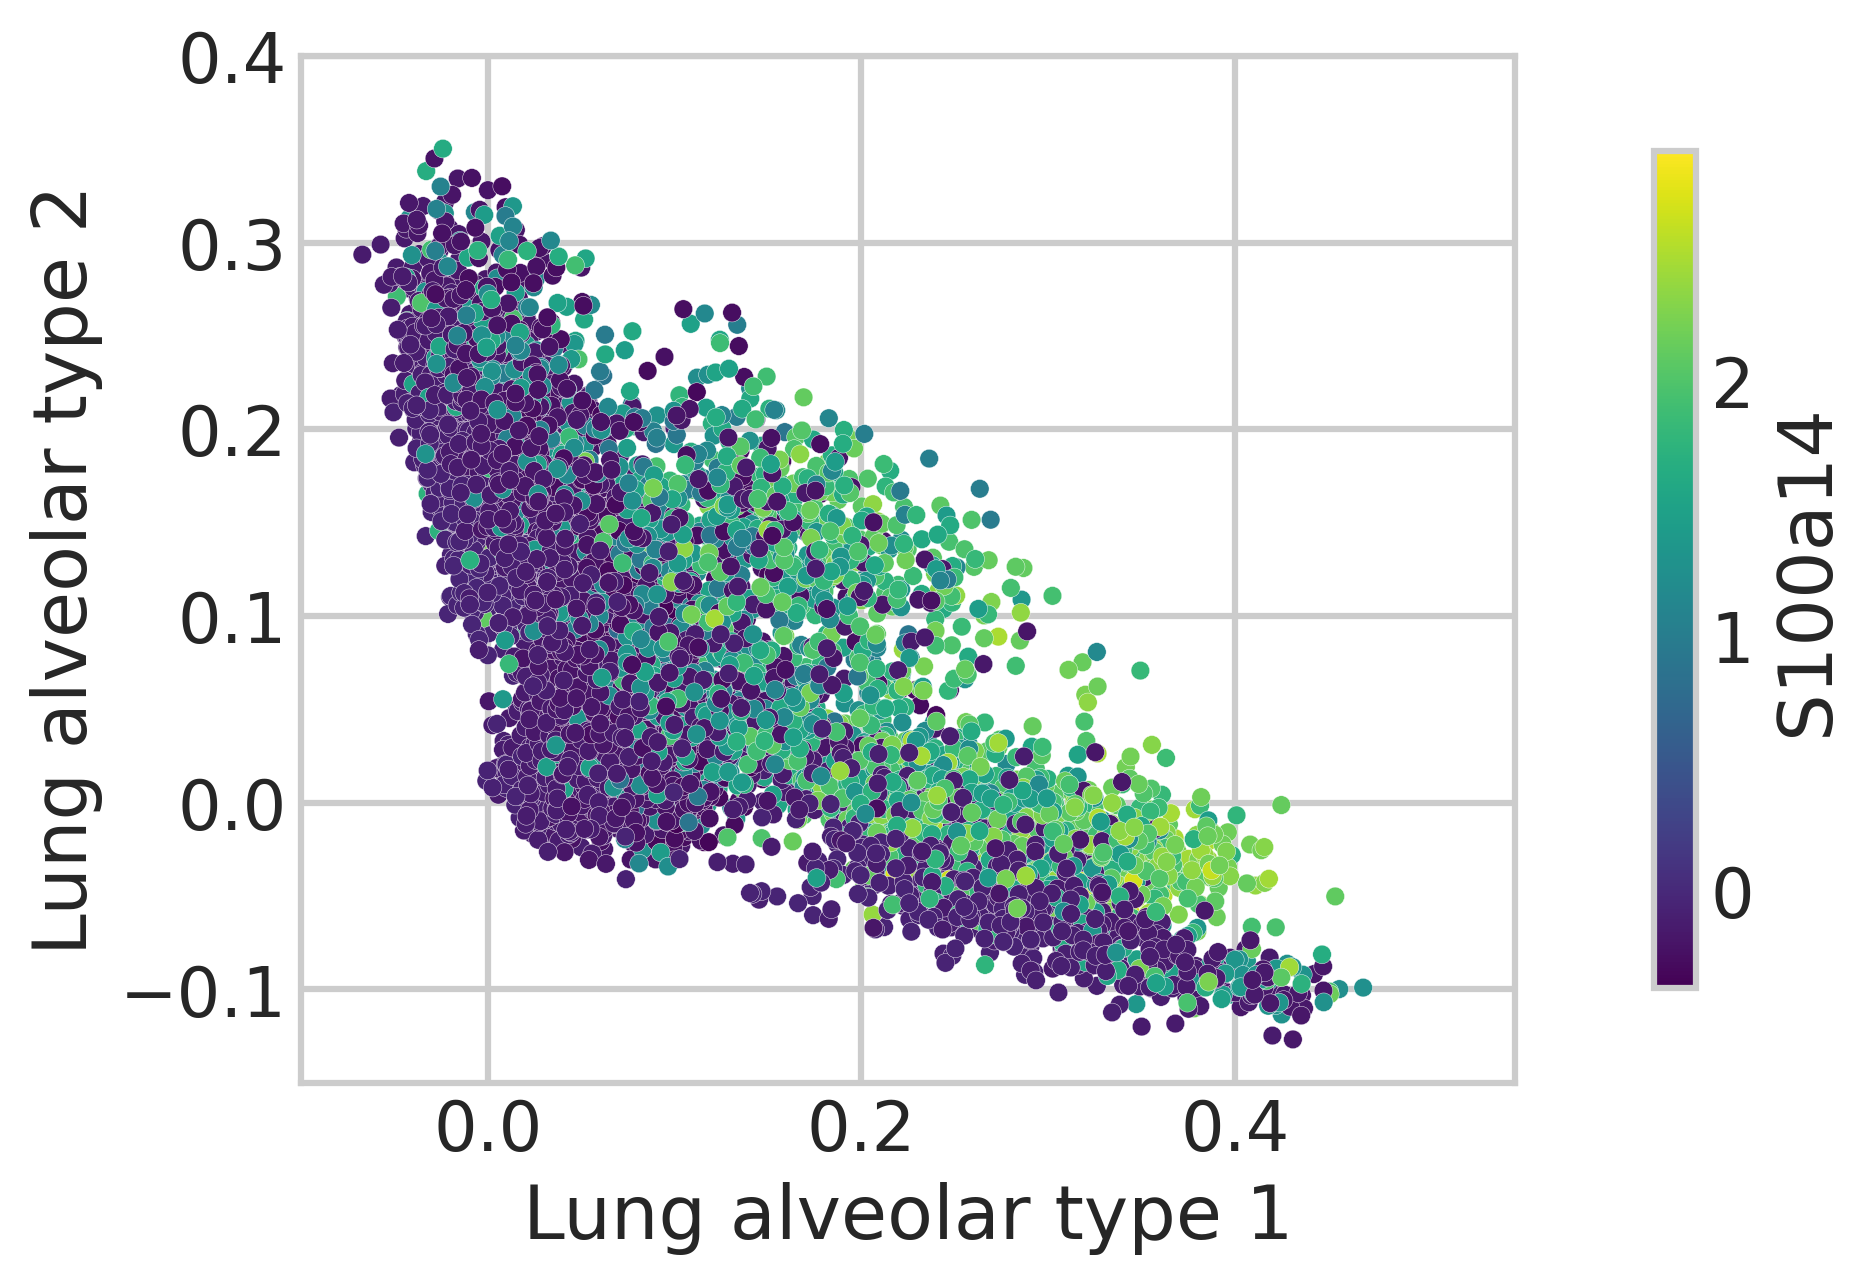

In [63]:
plt.figure(figsize=(6,6))

current_data = pd.concat([lungMAP_scores['type I pneumocyte'], lungMAP_scores['type II pneumocyte'], lungMAP_scores['progenitor cell']], axis=1)
typeX = 'Lung AT1 Cell WK6 KO22' # type to plot on x-axis
typeY = 'Lung AT2 Cell WK6 KO22' # type to plot on y-axis

# current_data = current_data.loc[:,current_data.loc['day'] == 'P3']
gene = 'S100a14'
# gene = 'Wnt2'
hue_array = pneumocytes.loc[gene]
    
cmap = create_colorbar(hue_array, gene,
                       colormap='viridis', ax = plt.gca()) 
    
sns.scatterplot(x=current_data.loc[typeX],
                y=current_data.loc[typeY],
                hue=hue_array,
                legend=False,
                palette='viridis',
                linewidth=0.1,
                s = 20,
                ax=plt.gca()
               )

plt.xlabel('Lung alveolar type 1')
plt.ylabel('Lung alveolar type 2')
plt.gca().set_aspect('equal')
plt.xlim([-0.1, 0.55])
plt.ylim([-0.15, 0.4])
plt.show()

# Time histogram

In [43]:
# Convert from time point labels to days pre- and post- birth
# Assume birth occurs at E19
birth_day = 21

day_conversion = {'E12.5': 12.5, 
                 'E15.5': 15.5, 
                 'E17.5': 17.5, 
                 'P3': 3 + birth_day, 
                 'P7': 7 + birth_day,  
                 'P15': 15 + birth_day,  
                 'P42': 42 + birth_day
                }

xbins = np.linspace(-0.1, 0.55, 100)
ybins = np.linspace(-0.15, 0.4, 100)

grid = np.meshgrid(xbins, ybins)

pneumocyte_scores = pd.concat([lungMAP_scores['type I pneumocyte'], lungMAP_scores['type II pneumocyte'], lungMAP_scores['progenitor cell']], axis=1)
pneumocyte_by_day = dict()

for day_string, day_value in day_conversion.items():
    pneumocyte_by_day[day_value] = pneumocyte_scores.loc[:,pneumocyte_scores.loc['day'] == day_string].drop('day')

def create_histogram(dataframe, type1, type2, xbins, ybins):
    histogram = np.histogram2d(x = dataframe.loc[type1],
                               y = dataframe.loc[type2],
                               bins = [xbins, ybins]
                              )
    histogram = pd.DataFrame(histogram[0].T) # take the transpose because np.histogram2d doesn't follow usual x/y conventions
    histogram = histogram/histogram.sum().sum()
    return histogram

def time_distribution(type1, type2, xbins, ybins):
    weighted_sum = 0
    hist_sum = 0
    for day, dataframe in pneumocyte_by_day.items():
        histogram = create_histogram(dataframe, type1, type2, xbins, ybins)
        weighted_sum += day*histogram
        hist_sum += histogram

    return weighted_sum/hist_sum

/scratch/146686.1.ood/ipykernel_17549/1602800366.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colormesh = plt.pcolormesh(grid[0], grid[1],
/scratch/146686.1.ood/ipykernel_17549/1602800366.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(colormesh, ax=plt.gca(), label='Days post-conception')


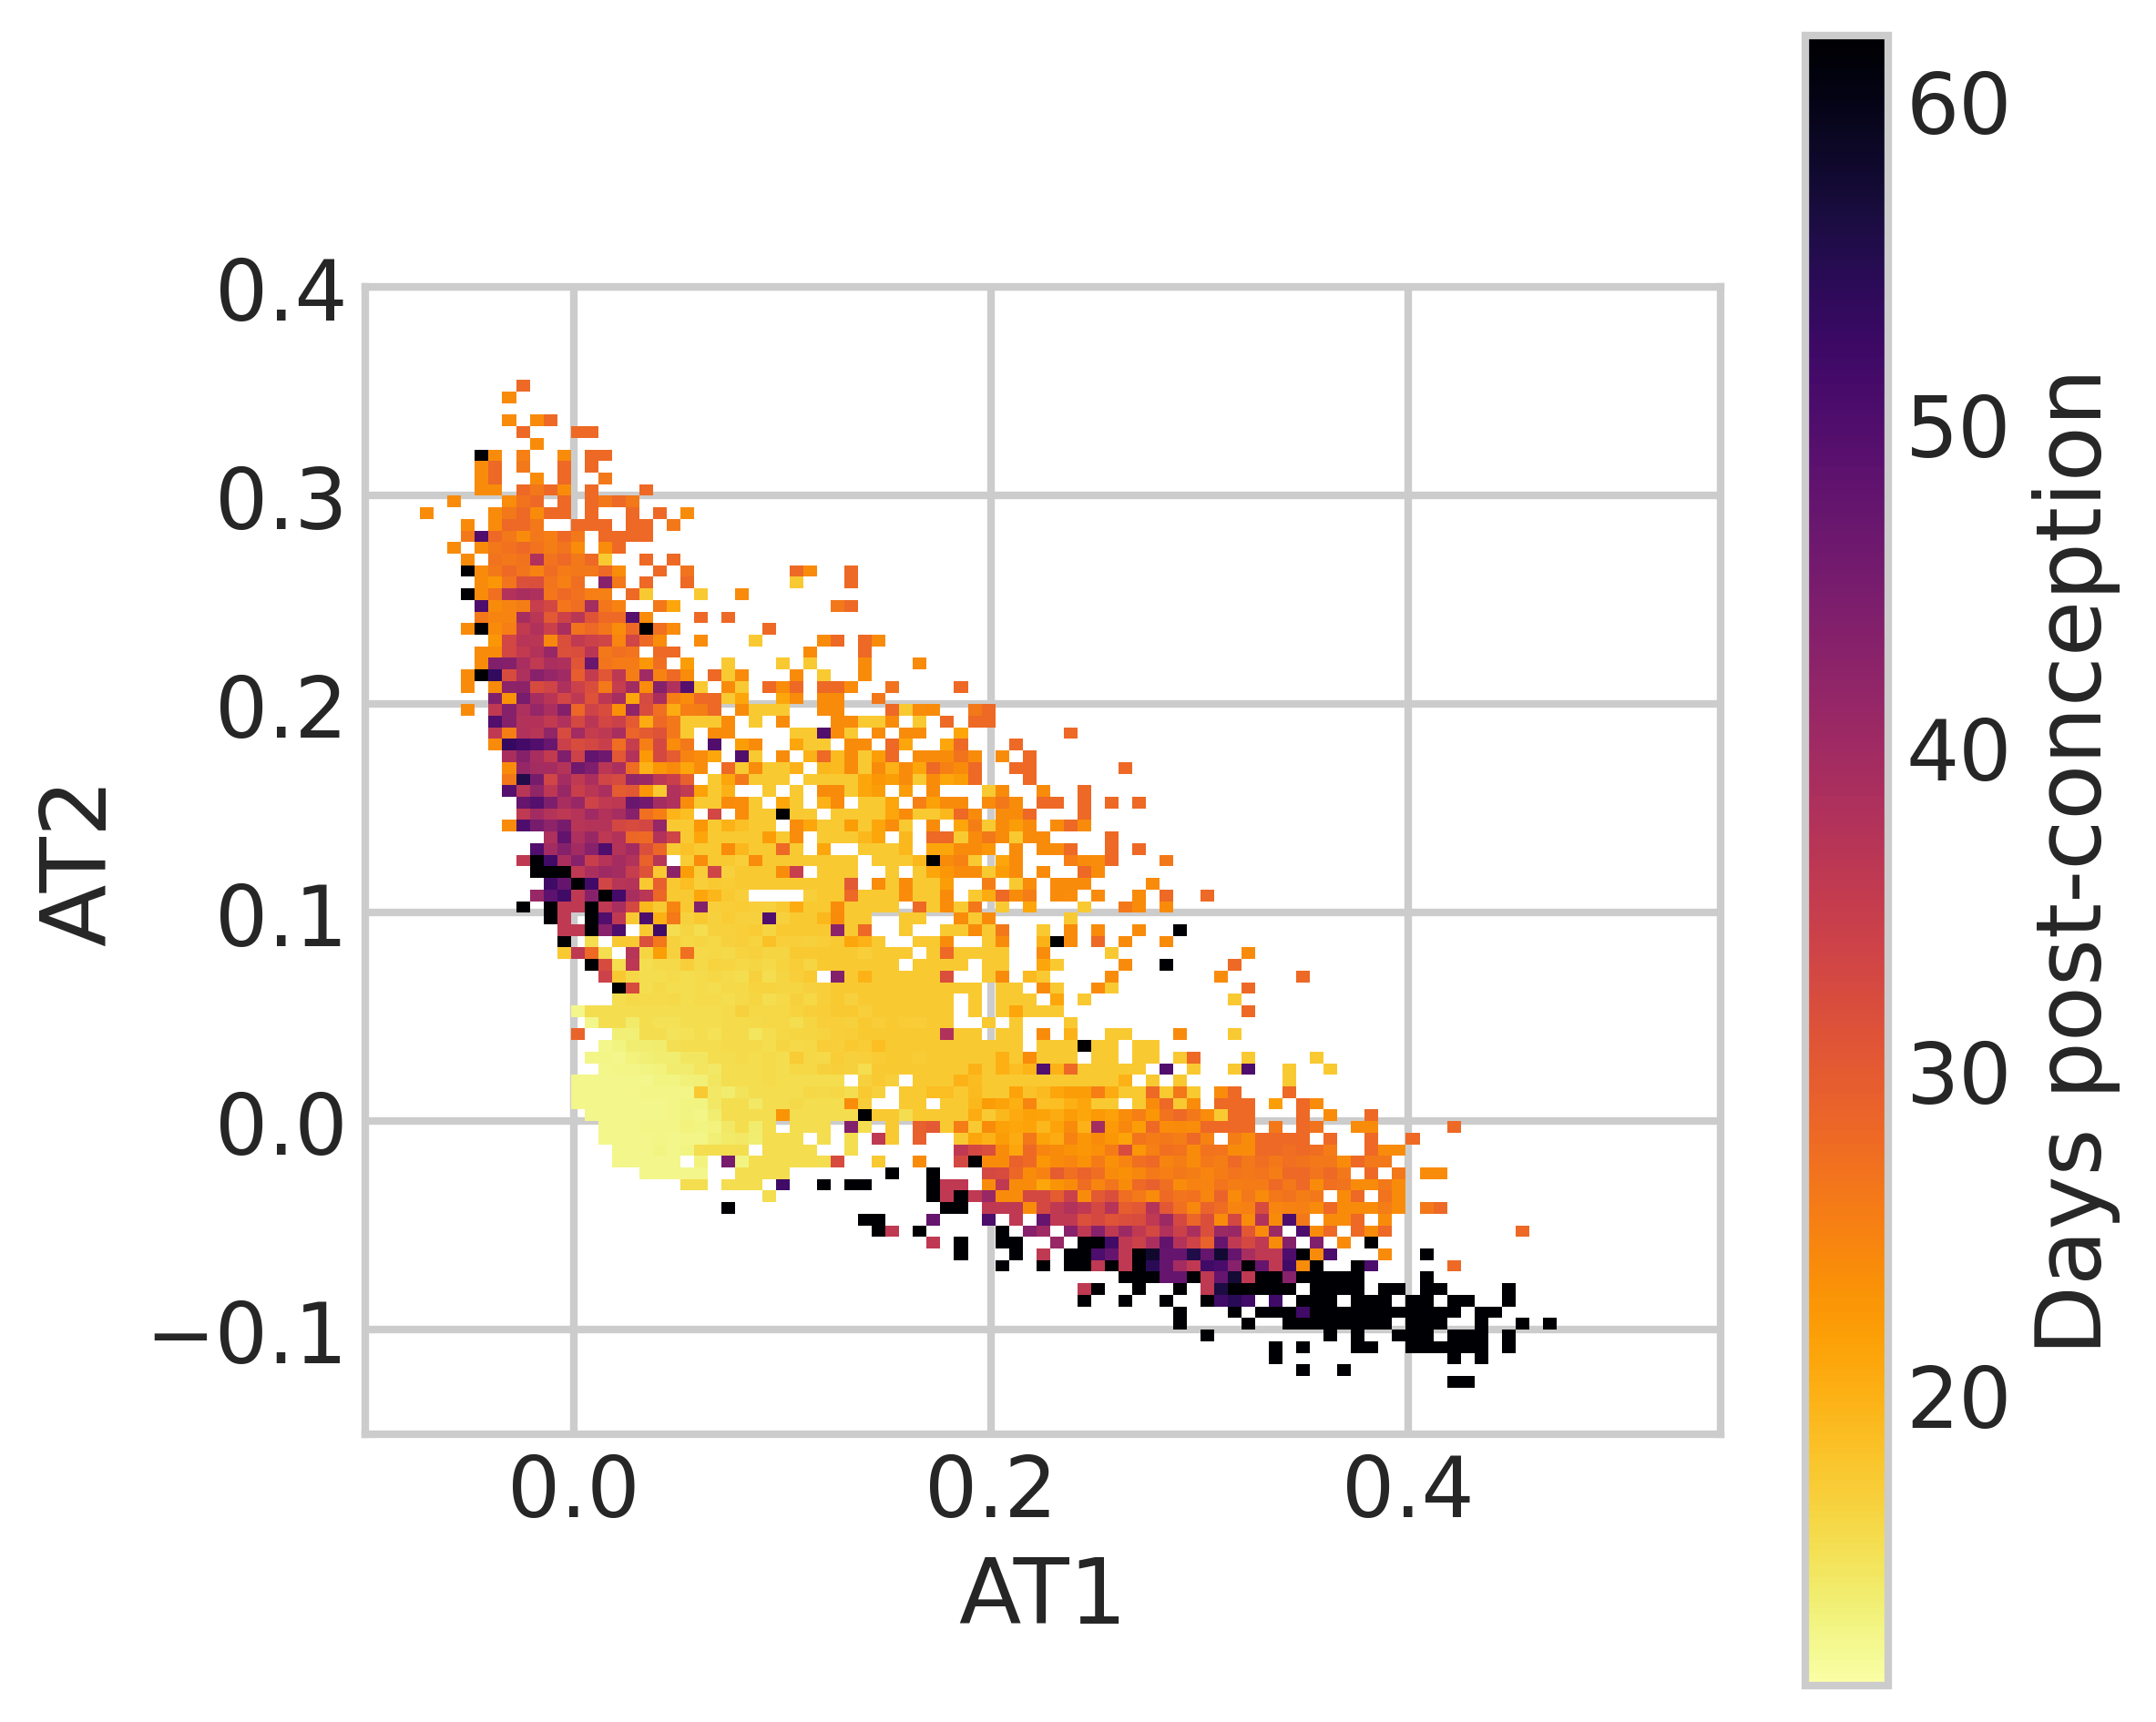

In [44]:
plt.figure(figsize=(6,6))
typeX = 'Lung AT1 Cell WK6 KO22' # type to plot on x-axis
typeY = 'Lung AT2 Cell WK6 KO22' # type to plot on y-axis

colormesh = plt.pcolormesh(grid[0], grid[1],
                                  time_distribution(typeX, typeY, xbins, ybins),
                                  vmin=11, vmax=62,
                                  cmap='inferno_r'
                                 )
        
plt.xlabel('AT1')
plt.ylabel('AT2')
plt.gca().set_aspect('equal')
plt.xlim([-0.1, 0.55])
plt.ylim([-0.15, 0.4])
plt.colorbar(colormesh, ax=plt.gca(), label='Days post-conception')
plt.grid()
        
plt.savefig('./manuscript figures/lungMAP_hists.png', bbox_inches = "tight")
plt.show()

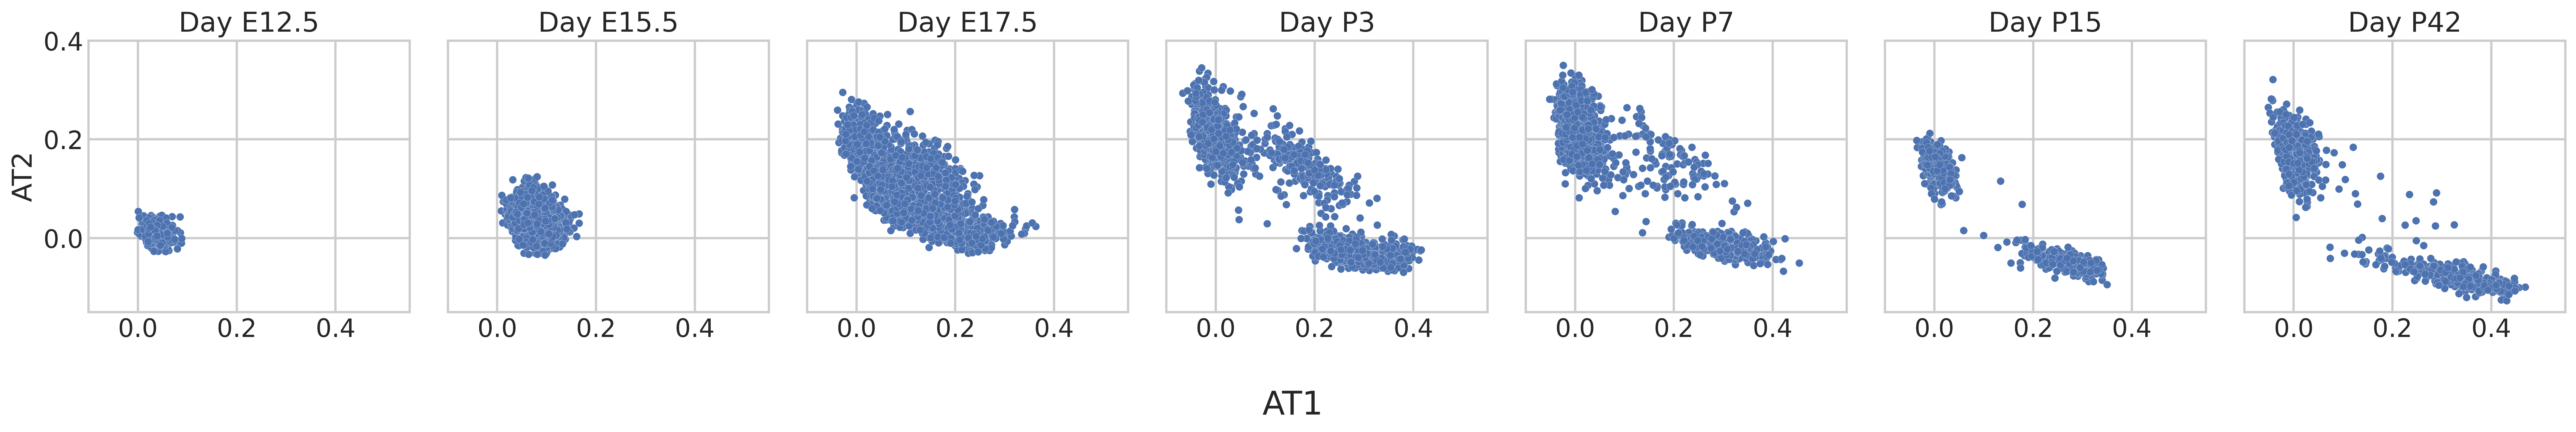

In [25]:
fig, axes = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(24,4))
axes_list = axes.flatten()

days = ['E12.5', 'E15.5', 'E17.5',  'P3', 'P7', 'P15', 'P42']

all_data = pd.concat([lungMAP_scores['type I pneumocyte'], lungMAP_scores['type II pneumocyte'], lungMAP_scores['progenitor cell']], axis=1)
typeX = 'Lung AT1 Cell WK6 KO22' # type to plot on x-axis
typeY = 'Lung AT2 Cell WK6 KO22' # type to plot on y-axis

for day, ax in zip(days, axes_list):
    current_data = all_data.loc[:,all_data.loc['day'] == day]

    sns.scatterplot(x=current_data.loc[typeX],
                    y=current_data.loc[typeY],
#                     style = current_data.loc[type_hue],
                    legend=False,
    #                 palette='inferno_r',
                    linewidth=0.1,
                    s = 25,
                    ax=ax
                   )

    ax.set_ylabel('AT2')
    ax.set_xlabel('')
    ax.set_aspect('equal')
    ax.set_xlim([-0.1, 0.55])
    ax.set_ylim([-0.15, 0.4])
    ax.set_title('Day {}'.format(day))


fig.supxlabel('AT1')
plt.tight_layout()
# fig.suptitle('Zepp et al. epithelial lung data')
plt.savefig("./manuscript figures/fig4_lungMAP_scatter_panel.png", bbox_inches = "tight")
plt.show()

In [9]:
pneumocytes_AT1

AAACGGGCATCGGGTC-E12.5    0.523636
AAAGTAGGTTCCGGCA-E12.5    0.140204
AACGTTGTCCTCAATT-E12.5    0.199773
AACTCTTAGCTAGTGG-E12.5    0.409126
AAGACCTAGTGGGATC-E12.5    0.119024
                            ...   
TTATGCTGTGGTACAG-Adult    0.801385
TTCCCAGCACCAGATT-Adult    1.911970
TTCTCCTTCCCATTTA-Adult    0.473687
TTCTCCTTCTTGTATC-Adult    1.666573
TTTATGCTCCTCAATT-Adult    0.711158
Length: 11389, dtype: float64

/scratch/151054.1.ood/ipykernel_21320/1878469578.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmap, label=label, **kwargs)


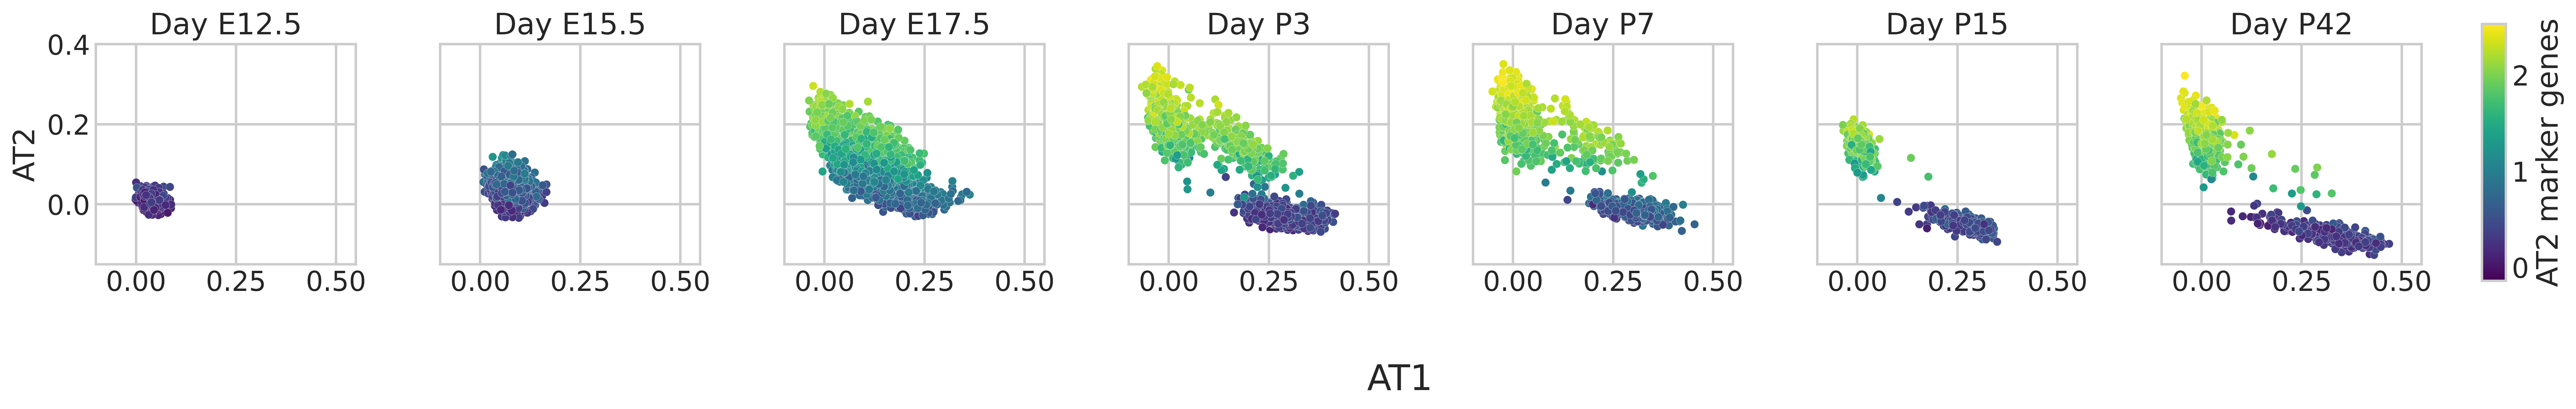

In [12]:
fig, axes = plt.subplots(1, 8, figsize=(24,4))
axes_list = axes.flatten()

days = ['E12.5', 'E15.5', 'E17.5',  'P3', 'P7', 'P15', 'P42']

all_data = pd.concat([lungMAP_scores['type I pneumocyte'], lungMAP_scores['type II pneumocyte'], lungMAP_scores['progenitor cell']], axis=1)
typeX = 'Lung AT1 Cell WK6 KO22' # type to plot on x-axis
typeY = 'Lung AT2 Cell WK6 KO22' # type to plot on y-axis

hue_data = pneumocytes_AT2

hue_norm = (min(hue_data), max(hue_data))

for day, ax in zip(days, axes_list):
    current_data = all_data.loc[:,all_data.loc['day'] == day]
    hue_array = hue_data.loc[current_data.columns]

    sns.scatterplot(x=current_data.loc[typeX],
                    y=current_data.loc[typeY],
                    hue = hue_array,
                    legend=False,
                    palette='viridis',
                    linewidth=0.1,
                    s = 25,
                    hue_norm = hue_norm,
                    ax=ax
                   )
    
    if ax == axes_list[0]:
        ax.set_ylabel('AT2')
    else:
        ax.tick_params(axis='y', labelleft=False)
        ax.set_ylabel('')
        
    ax.set_xlabel('')
    ax.set_aspect('equal')
    ax.set_xlim([-0.1, 0.55])
    ax.set_ylim([-0.15, 0.4])
    ax.set_title('Day {}'.format(day))
    
    
plt.tight_layout()

ax = axes_list[-1]
cmap = create_colorbar(hue_norm, 'AT2 marker genes',
                           colormap='viridis', cax = ax)

bbox=ax.get_position()
ax.set_position([bbox.x0-0.05, bbox.y0+0.12, bbox.x1 - bbox.x0, (bbox.y1 - bbox.y0)*0.7], which='both')
ax.set_aspect(4)
fig.supxlabel('AT1')
plt.savefig("./manuscript figures/fig4_lungMAP_scatter_panel_AT2.png", bbox_inches = "tight")
plt.show()

/scratch/146686.1.ood/ipykernel_17549/1878469578.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmap, label=label, **kwargs)


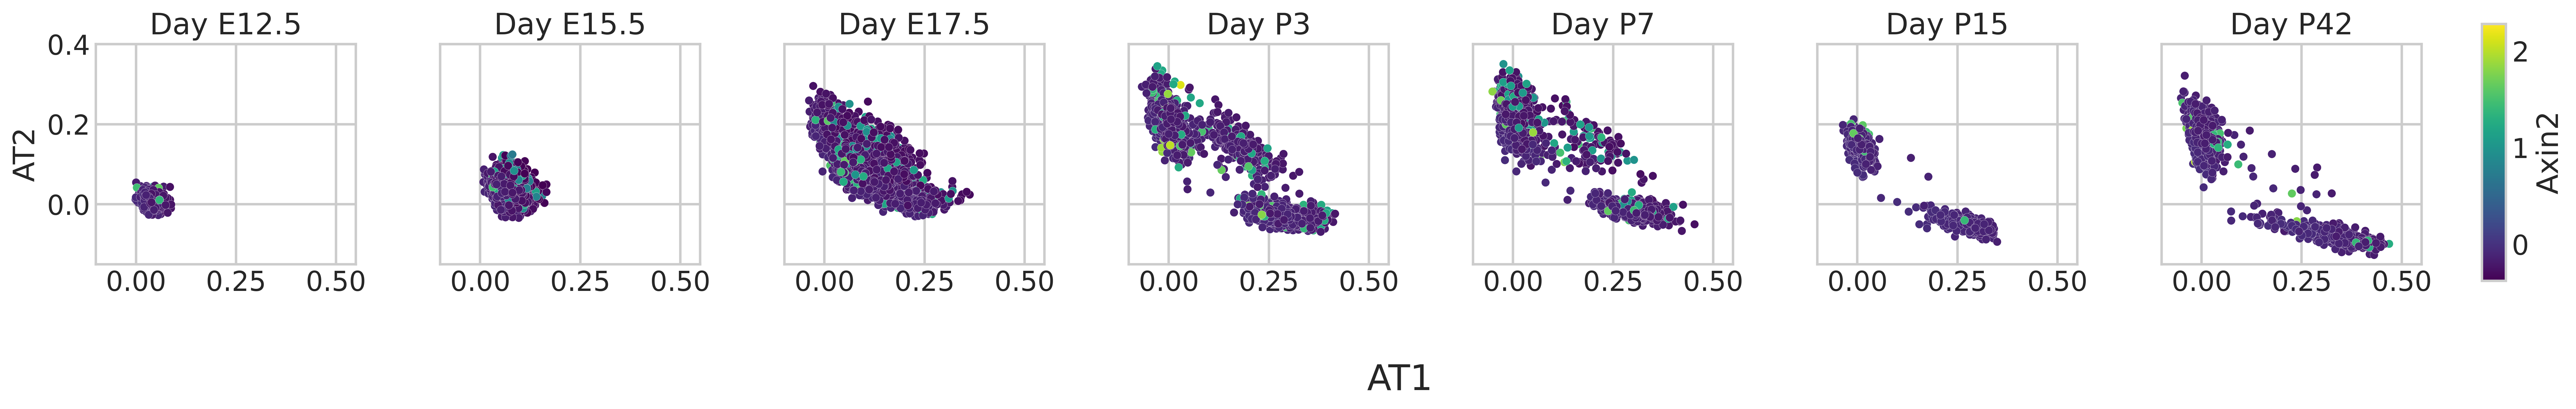

In [38]:
fig, axes = plt.subplots(1, 8, figsize=(24,4))
axes_list = axes.flatten()

days = ['E12.5', 'E15.5', 'E17.5',  'P3', 'P7', 'P15', 'P42']

all_data = pd.concat([lungMAP_scores['type I pneumocyte'], lungMAP_scores['type II pneumocyte'], lungMAP_scores['progenitor cell']], axis=1)
typeX = 'Lung AT1 Cell WK6 KO22' # type to plot on x-axis
typeY = 'Lung AT2 Cell WK6 KO22' # type to plot on y-axis

gene = 'Axin2'

hue_norm = (min(pneumocytes.loc[gene]), max(pneumocytes.loc[gene]))

for day, ax in zip(days, axes_list):
    current_data = all_data.loc[:,all_data.loc['day'] == day]
    hue_array = pneumocytes.loc[gene, current_data.columns]

    sns.scatterplot(x=current_data.loc[typeX],
                    y=current_data.loc[typeY],
                    hue = hue_array,
                    legend=False,
                    palette='viridis',
                    linewidth=0.1,
                    s = 25,
                    hue_norm = hue_norm,
                    ax=ax
                   )
    
    if ax == axes_list[0]:
        ax.set_ylabel('AT2')
    else:
        ax.tick_params(axis='y', labelleft=False)
        ax.set_ylabel('')
        
    ax.set_xlabel('')
    ax.set_aspect('equal')
    ax.set_xlim([-0.1, 0.55])
    ax.set_ylim([-0.15, 0.4])
    ax.set_title('Day {}'.format(day))
    
    
plt.tight_layout()

ax = axes_list[-1]
cmap = create_colorbar(hue_norm, gene,
                           colormap='viridis', cax = ax)

bbox=ax.get_position()
ax.set_position([bbox.x0-0.05, bbox.y0+0.12, bbox.x1 - bbox.x0, (bbox.y1 - bbox.y0)*0.7], which='both')
ax.set_aspect(4)
fig.supxlabel('AT1')
# fig.suptitle('Zepp et al. epithelial lung data, colored by gene {}'.format(gene))
plt.savefig("./manuscript figures/fig4_lungMAP_scatter_panel_{}.png".format(gene), bbox_inches = "tight")
plt.show()

# Try to identify differential genes with scanpy

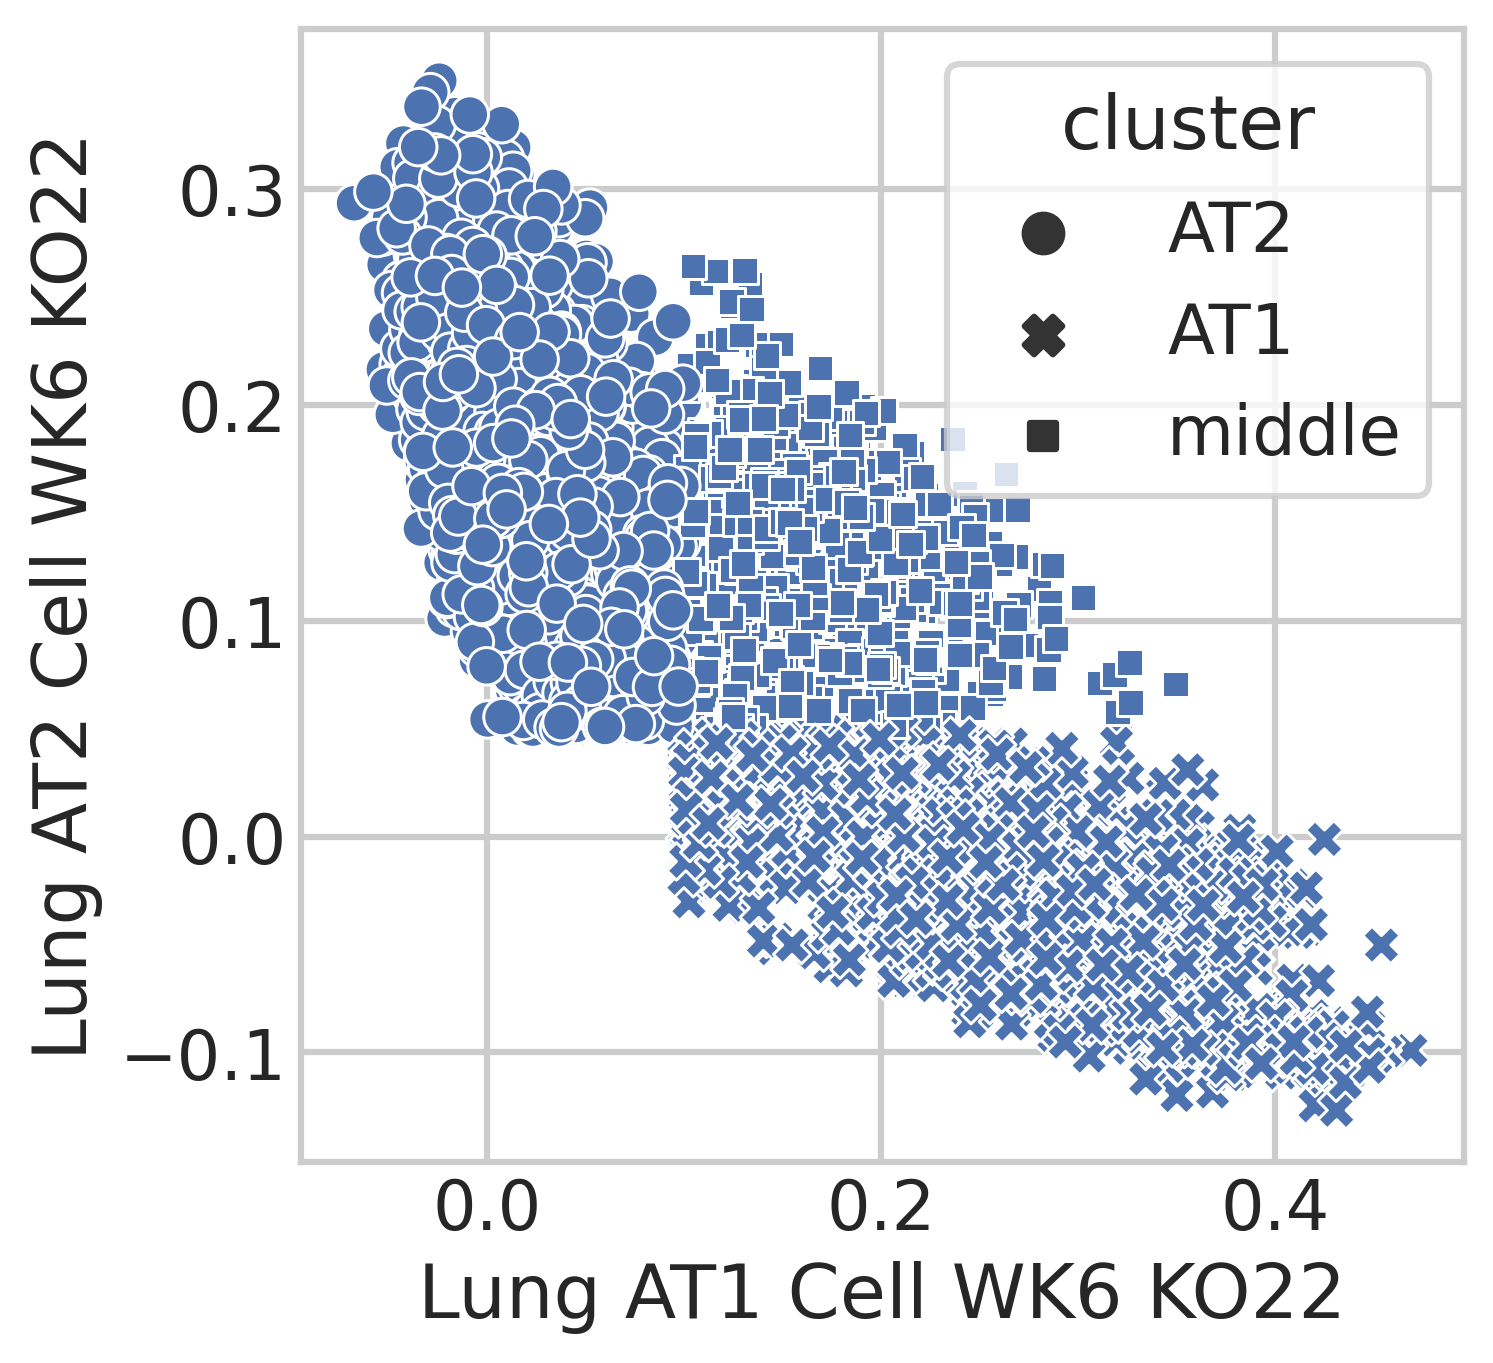

In [28]:
plt.figure(figsize=(5,5))
sns.scatterplot(x=all_data.loc[typeX],
                    y=all_data.loc[typeY],
                    style=labels.loc['cluster'],
                   )
plt.show()

In [10]:
typeX = 'Lung AT1 Cell WK6 KO22' # type to plot on x-axis
typeY = 'Lung AT2 Cell WK6 KO22' # type to plot on y-axis

bound_x = 0.1
bound_y = 0.05

middle_cluster = pneumocytes.loc[:, np.logical_and(all_data.loc[typeX] > bound_x, all_data.loc[typeY] > bound_y)].columns
AT1_cluster = pneumocytes.loc[:, np.logical_and(all_data.loc[typeX] > bound_x, all_data.loc[typeY] < bound_y)].columns
AT2_cluster = pneumocytes.loc[:, np.logical_and(all_data.loc[typeX] < bound_x, all_data.loc[typeY] > bound_y)].columns

labels = pd.DataFrame()
labels.loc['cluster', middle_cluster] = np.full_like(middle_cluster, 'middle')
labels.loc['cluster', AT1_cluster] = np.full_like(AT1_cluster, 'AT1')
labels.loc['cluster', AT2_cluster] = np.full_like(AT2_cluster, 'AT2')

In [11]:
import scanpy as sc

adata = sc.AnnData(pneumocytes.T)
adata.obs['cluster'] = labels.loc['cluster'] #all_data.loc['annotation']

/scratch/146045.1.ood/ipykernel_12451/2406207005.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(pneumocytes.T)
/projectnb2/biophys/mariay/venvs/myenv/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/projectnb2/biophys/mariay/venvs/myenv/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/projectnb2/biophys/mariay/venvs/myenv/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/projectnb2/biophys/mariay/venvs/myenv/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


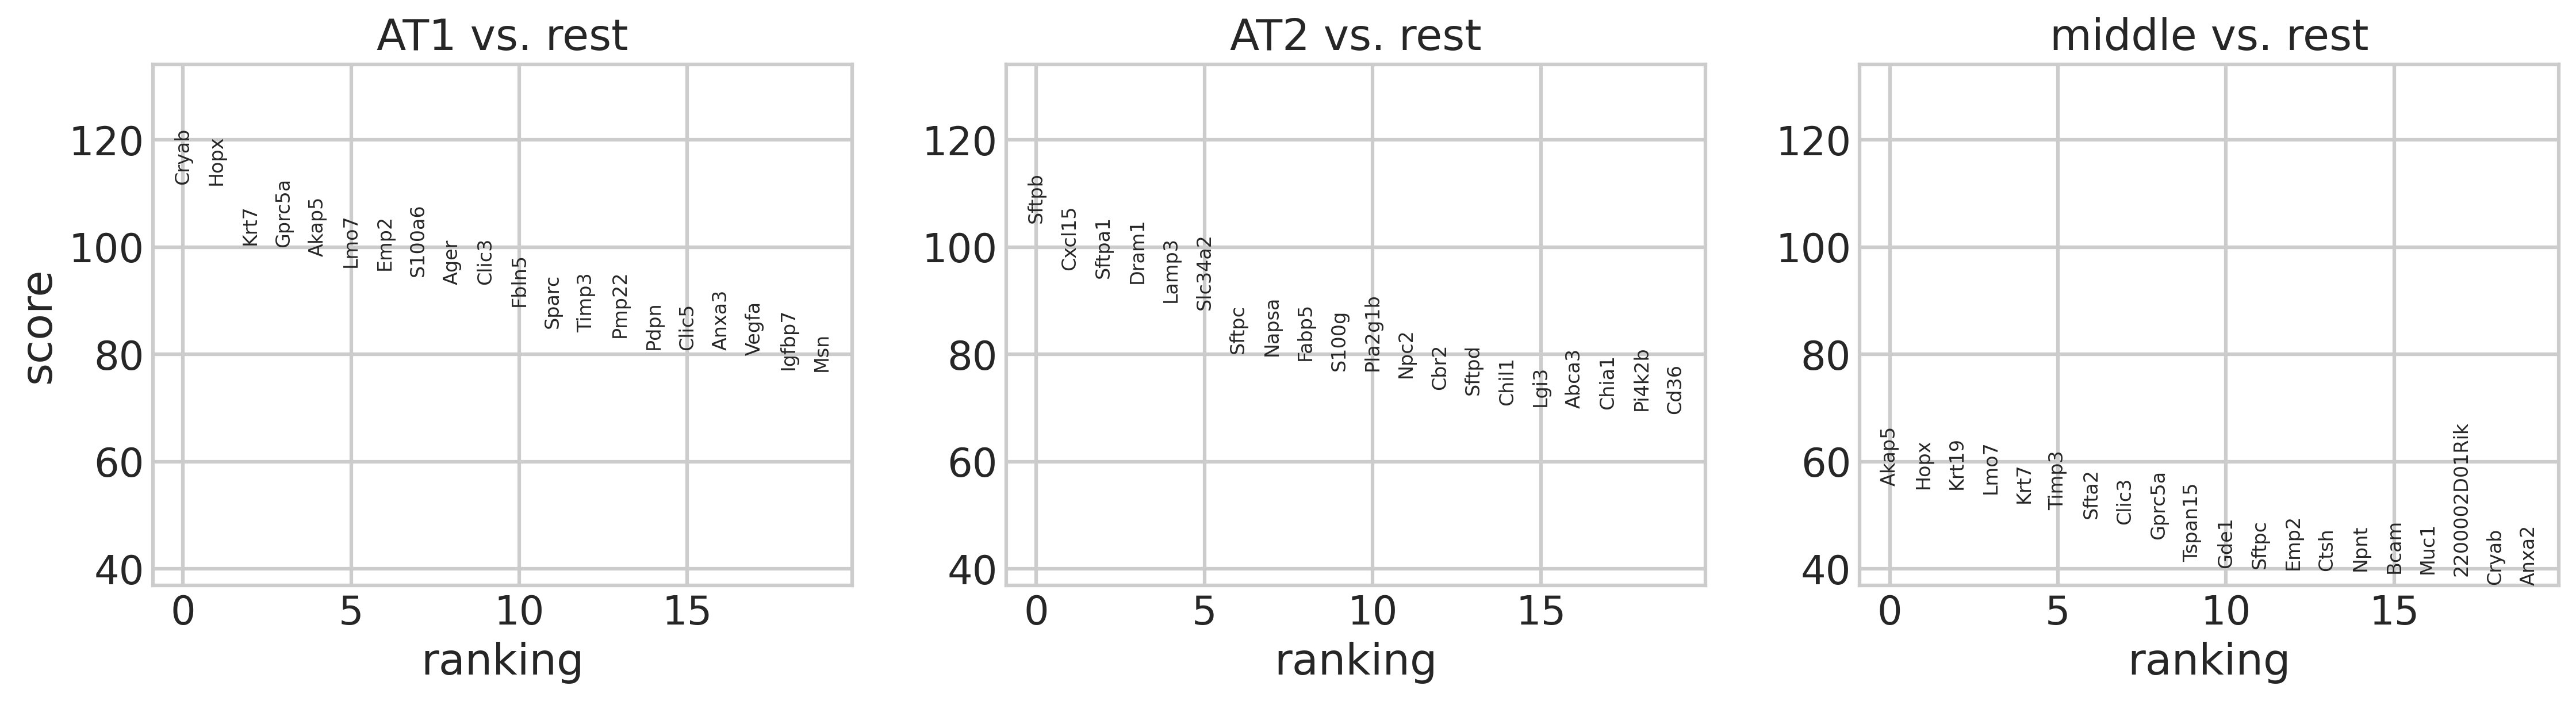

In [14]:
sc.tl.rank_genes_groups(adata, 'cluster')#, method='wilcoxon')
sc.pl.rank_genes_groups(adata)